# Import Libraries


In [23]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from utils import flatten_datasets, fine_tune
from config import models

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Prepare Test Data

We prepare our test dataset by using the `test_set`. We ensure the same split as earlier since the seed value used in the other pipelines is the same.


In [24]:
flag = 1

base_model = models[flag]["base_model"]
model_name = models[flag]["model_name"]
num_layers_to_freeze = models[flag]["num_layers_to_freeze"]
config = models[flag]["config"]

In [25]:
data_dir = "dataset/4-augmented"
class_names = os.listdir(data_dir)

test_dir = os.path.join(data_dir, "test")

test_set = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=config["seed_value"],
    image_size=config["img_shape"],
    batch_size=config["batch_size"],
    label_mode="binary",
)

test_images, test_labels = flatten_datasets(test_set)

Found 45 files belonging to 2 classes.


# Defining the Base Model

This project will be using EfficientNetV2-B0 and MobileNetV3-Small. We can easily get this from the TensorFlow API. Let's set a `flag` variable so we can easily set which model we want to test with.


In [26]:
checkpoints_path = f"checkpoints/fine-tune/{model_name}"
latest_checkpoint = tf.train.latest_checkpoint(checkpoints_path)
model = fine_tune(base_model, config, num_layers_to_freeze)
model.load_weights(latest_checkpoint)

results = model.evaluate(test_set)

1/1 [==============================] - 2s 2s/step - loss: 0.2176 - precision: 1.0000 - recall: 0.5714 - f1_score: 0.7273 - false_negatives: 3.0000 - true_positives: 4.0000 - false_positives: 0.0000e+00 - true_negatives: 38.0000


# Prepare Grad-CAM++


In [27]:
replace2linear = ReplaceToLinear()
X = np.asarray(test_images.astype(np.float32))
test_labels = list(np.array(test_labels).argmax(axis=1))
# X = np.asarray(np.asarray(healthy_images).astype(np.float32))
score = CategoricalScore(test_labels)
# score = CategoricalScore(healthy_labels)

gradcam = GradcamPlusPlus(
    model.get_layer(model_name),
    model_modifier=replace2linear,
    clone=True,
)

cam = gradcam(score, X, penultimate_layer=-1)

In [30]:
predictions = model.predict(test_images).argmax(axis=1)

# plt.figure(figsize=(30, 30), dpi=150)
# fig, ax = plt.subplots(1, 10, figsize=(15, 15), dpi=150)

# get only healthy images and index in the variable cam
# healthy_images, healthy_labels = [], []
# wssv_images, wssv_labels = [], []
# for i, label in enumerate(test_labels):
#     if label == 0:
#         healthy_images.append(test_images[i])
#         healthy_labels.append(i)

#     if label == 1:
#         wssv_images.append(test_images[i])
#         wssv_labels.append(i)
j = 1
plt.figure(figsize=(15, 8), dpi=150)
for i, index in enumerate(test_labels):
    # heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

    # plt.subplot(9, 5, i + 1)
    # plt.imshow(test_images[i] / 255)
    # plt.imshow(heatmap, cmap="jet", alpha=0.25)
    # plt.axis("off")

    # if i == 44:
    #     break

    if index == 1:
        plt.subplot(2, 5, j)
        j += 1
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        # put prediction and true label on top of image, then highlight it red if wrong prediction

        misclassified = predictions[i] != index
        if misclassified:
            plt.title(
                f"Prediction: {class_names[predictions[i]]}\n True label: {class_names[index]}",
                color="red",
            )
        else:
            plt.title(
                f"Prediction: {class_names[predictions[i]]}\n True label: {class_names[index]}"
            )

        plt.imshow(test_images[i] / 255)
        plt.imshow(heatmap, cmap="jet", alpha=0.25)
        plt.axis("off")

    if i == 44:
        break

# for i, index in enumerate(wssv_labels):
#     heatmap = np.uint8(cm.jet(cam[index])[..., :3] * 255)

#     ax[1, i].imshow(wssv_images[i] / 255)
#     ax[1, i].imshow(heatmap, cmap="jet", alpha=0.25)
#     ax[1, i].axis("off")

#     if i == 4:
#         break

plt.tight_layout()
plt.show()

2/2 [==============================] - 0s 8ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<Figure size 2250x1200 with 0 Axes>

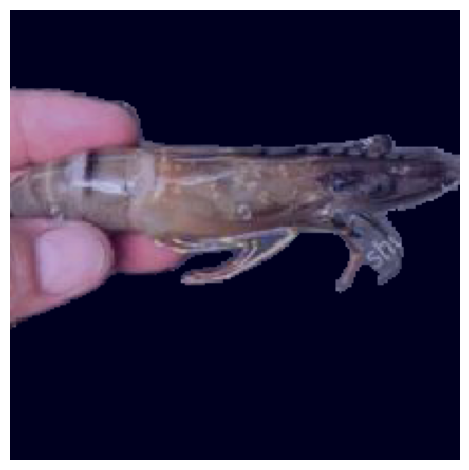

In [29]:
filename = "dataset/wssv_bg_cleaned-removebg-preview.png"
# filename = "dataset/wssv_bg_cleaned.png"
image = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))

gradcam = GradcamPlusPlus(
    model.get_layer(model_name),
    model_modifier=replace2linear,
    clone=True,
)

images = np.asarray([np.array(image).astype(np.float32)])
score = CategoricalScore([1])
cam = gradcam(score, images, penultimate_layer=-1)

heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
plt.imshow(images[0] / 255)
plt.imshow(heatmap, cmap="jet", alpha=0.25)  # overlay
plt.axis("off")
plt.tight_layout()
plt.show()